In [1]:
import numpy as np

# np.random.seed(0) # REMOVE FOR FINAL SOLUTION

In [58]:
def splitData(data):
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    testCount = int(shuffled.shape[0]*1/3)
    trainCount = shuffled.shape[0]-testCount
    trainSet = shuffled[0:trainCount]
    testSet = shuffled[trainCount:]

    return trainSet, testSet

def separateInputOutput(dataset):
    outputData = dataset[:,3] # Output
    inputData = np.concatenate((dataset[:,0:3],dataset[:,4:7],dataset[:,8:10]),axis=1)
    return inputData, outputData

def getInputAttributeDict():
    return {   0 : 'calorific_value',
                    1 : 'nitrogen',
                    2 : 'turbidity',
                    3 : 'alcohol',
                    4 : 'sugars',
                    5 : 'bitterness',
                    6 : 'colour',
                    7 : 'degree_of_fermentation'} .copy()

# def initializeWeights(x,y):
#     N = x.shape[0]
    
def normaliseData(data, normType = "range"):
    normalisedData = np.zeros(data.shape)
    for i in range(normalisedData.shape[1]):
        dataColumn = data[:,i].copy()
        if normType == "range":
            maxVal = dataColumn.max()
            minVal = dataColumn.min()
            for j, val in enumerate(dataColumn):
                normalisedData[j,i] = (val-minVal)/(maxVal-minVal)


        elif normType == "z":
            mean = dataColumn.mean()
            stdDev =  getStandardDeviation(dataColumn)
            for j, val in enumerate(dataColumn):
                normalisedData[j,i] = (val-mean)/stdDev
    return normalisedData

def getStandardDeviation(dataArray):
    n = dataArray.shape[0]
    mean = dataArray.mean()
    sumOfSquareDiffs = 0
    for val in dataArray:
        sumOfSquareDiffs += (val - mean)**2

    variance = sumOfSquareDiffs/(n-1)
    stdDev = variance**(1/2)
    return stdDev

In [40]:
# Read in data:
with open("beer.txt", 'r') as f:
    lines = np.asarray(f.read().split('\n'))

dataset = []
# Split columns and convert numbers from string to float
for lineStr in lines: 
    attributesStr = lineStr.split('\t') # Separate attributes (currently all strings)
    sample = np.empty((len(attributesStr))).astype(object) # Create empty object array for sample data as floats and str
    for i, string in enumerate(attributesStr):
        try:
            sample[i] = float(string)
        except ValueError:
            sample[i] = string
    dataset.append(sample)
dataset = np.asarray(dataset)


trainSet, testSet = splitData(dataset)

testIn, testOut = separateInputOutput(testSet)
trainIn, trainOut = separateInputOutput(trainSet)

N =trainIn.shape[0]
# Wi = 1/N
# print(getInputAttributeDict()[1])



122.0 47.0 16.0 26.0


In [4]:
def getUniqueClassCount(listToCount):
    classes = []
    for item in listToCount:
        if item not in classes:
            classes.append(item)

    counts = []
    for itemClass in classes:
        counts.append(listToCount.count(itemClass))
    return counts, classes

def getLeafGini(counts):
    total = np.sum(counts)
    giniLeaf = 1
    for count in counts:
        giniLeaf -= (count/total)**2
    return giniLeaf

def getNodeGini(sortedList, threshold):
        lessThan = []
        greaterThan = []

        for i in range(len(sortedList)):
            x = sortedList[i][0]
            # print(x, threshold)
            if x < threshold:
                lessThan.append(sortedList[i][1])
            else:
                greaterThan.append(sortedList[i][1])

        countsLT, _ = getUniqueClassCount(lessThan)
        countsGT, _ = getUniqueClassCount(greaterThan)
        giniLT = getLeafGini(countsLT)
        giniGT = getLeafGini(countsGT)
        # print(giniLT,giniGT)
        # print(np.sum(countsLT),np.sum(countsGT))
        totalCount = len(sortedList)
        # print(totalCount, (len(lessThan)+len(greaterThan)))
        nodeGini = ((np.sum(countsLT)/totalCount)*giniLT) + ((np.sum(countsGT)/totalCount)*giniGT)
        # print(giniNode)
        return nodeGini


In [5]:
def getMinGiniAndThreshold(inputData, outputData, alreadyUsedAttributes):
    inputAttributesMinGinis = []
    attributeThresholds = []
    attributeIndexes = list(getInputAttributeDict())
    # print(attributeIndexes)
    for i in alreadyUsedAttributes:
        attributeIndexes.remove(i)
    # print("Getting gini of attributes {}".format(attributeIndexes))
    
    for i in attributeIndexes:
        attribute = inputData[:, i].copy() # Single attribute from input data
        
        inputOutputPairs = []
        for j,sample in enumerate(attribute):
            inputOutputPairs.append((sample,outputData[j]))
        attribute.sort()

        sortedInputOutputPairs = [tuple for x in attribute for tuple in inputOutputPairs if tuple[0] == x]
        # print(len(sortedInputOutputPairs), len(attribute))
        # print(attribute[-1], sortedInputOutputPairs[-1])
        testThresholds = []
        for j in range(len(attribute)-1):
            testThresholds.append((attribute[j]+attribute[j+1])/2)

        nodeGinis = []
        for testThresh in testThresholds:
            nodeGinis.append(getNodeGini(sortedInputOutputPairs, testThresh))

        minNodeGini = min(nodeGinis)
        minGiniIndex = nodeGinis.index(minNodeGini)
        attributeThreshold = testThresholds[minGiniIndex]

        inputAttributesMinGinis.append(minNodeGini)
        attributeThresholds.append(attributeThreshold)
    return inputAttributesMinGinis, attributeThresholds
   

In [6]:
def createTree(trainIn,trainOut):
    attributesUsed = []
    return recursiveBranch(trainIn, trainOut, 1, attributesUsed, None)
    

def recursiveBranch(inputData, outputData, parentGini, attributesUsed, currentNode):

    if currentNode == None: # Make root node
        minAttributeGinis, attributeThresholds = getMinGiniAndThreshold(inputData, outputData, attributesUsed)
        nodeAttributeGini = min(minAttributeGinis)

        nodeAttributeIndex = minAttributeGinis.index(nodeAttributeGini)
        attributesUsed.append(nodeAttributeIndex)

        # print("Node attribute index (lowest gini) =",nodeAttributeIndex)

        nodeThreshold = attributeThresholds[minAttributeGinis.index(nodeAttributeGini)]
        # print("Root node created using attribute {} (has a min gini of {:.5f}). Threshold at this node = {}. Parent node gini = {:.5f}.".format(nodeAttributeIndex, nodeAttributeGini, nodeThreshold, parentGini))

        rootNode = Node(nodeAttributeIndex, nodeThreshold)
        branchData(inputData, outputData, nodeAttributeGini, nodeThreshold, nodeAttributeIndex, attributesUsed, rootNode)
        # print("Back to root")
        return rootNode

    # print("Attributes Used = {}".format(attributesUsed))#[getInputAttributeDict()[i] for i in attributesUsed]))
    
    if inputData.shape[0] <= 1:
        # print("Leaf created - Just one sample remaining:", outputData)
        currentNode.setValue(outputData)
        return
        
    if len(getUniqueClassCount(list(outputData))[0]) == 1:
        # print("Leaf created - Remaining {} samples are all \"{}\".".format(inputData.shape[0], outputData[0]))
        currentNode.setValue(outputData)
        return

    if len(attributesUsed) >= len(inputData)-1: ## -------------------TEST
        # print("Leaf created - All attributes have been used in current branch.")
        currentNode.setValue(outputData)
        # print(outputData)
        return
    else: # Check ginis
        minAttributeGinis, attributeThresholds = getMinGiniAndThreshold(inputData, outputData, attributesUsed)
        nodeAttributeGini = min(minAttributeGinis)

    # try:
    minAttributeGinis, attributeThresholds = getMinGiniAndThreshold(inputData, outputData, attributesUsed)
    nodeAttributeGini = min(minAttributeGinis)

    # If none of the new ginis is less than parent gini, exit recursion
    if parentGini < nodeAttributeGini:
        # print("Leaf created - Min gini of remaining attributes ({:.5f}) is less than parent node gini ({:.5f}).".format(nodeAttributeGini, parentGini))
        currentNode.setValue(outputData)
        return

    # Not leaf -> Continue recursion
    attributeIndexes = list(getInputAttributeDict()) # Get full attribute list
    for i in attributesUsed:                         # Remove previously used attributes
        attributeIndexes.remove(i)                  
    nodeAttributeIndex = attributeIndexes[minAttributeGinis.index(nodeAttributeGini)] # Get index of new attribute to use 
    attributesUsed.append(nodeAttributeIndex)                                         # Add to list of used attributes
    # print("Node attribute index (lowest gini) =",nodeAttributeIndex)

    nodeThreshold = attributeThresholds[minAttributeGinis.index(nodeAttributeGini)] # Get threshold for new node
    # print("Branch node created using attribute {} (has a min gini of {:.5f}). Threshold at this node = {}. Parent node has gini = {:.5f}.".format(nodeAttributeIndex, nodeAttributeGini, nodeThreshold, parentGini))
    currentNode.setValue(nodeThreshold)
    currentNode.setIndex(nodeAttributeIndex)
    branchData(inputData, outputData, nodeAttributeGini, nodeThreshold, nodeAttributeIndex, attributesUsed, currentNode)
    return
    # except:
    #     print("Attributes Used = {}".format(attributesUsed))#[getInputAttributeDict()[i] for i in attributesUsed]))
    #     print("OutputData:",outputData)


In [7]:
def branchData(X, y, splitAttributeGini, splitValue, splitAttributeIndex, attributesUsed, currentNode):
    lessThan_X = []
    lessThan_y = []
    greaterThan_X = []
    greaterThan_y = []

    for i in range(len(X)):
        if X[i,splitAttributeIndex] < splitValue:
            lessThan_X.append(X[i,:])
            lessThan_y.append(y[i])
        else:
            greaterThan_X.append(X[i,:])
            greaterThan_y.append(y[i])

    # left branch first:
    attributesUsed_left = attributesUsed.copy()
    attributesUsed_right = attributesUsed.copy()

    currentNode.addLeftChild(Node())
    currentNode.addRightChild(Node())

    # currentNode_right = currentNode.copy()
    
    lessThan_X = np.asarray(lessThan_X)
    lessThan_y = np.asarray(lessThan_y)
    # print("\nBranching left...")
    recursiveBranch(lessThan_X, lessThan_y, splitAttributeGini, attributesUsed_left, currentNode.getLeftChild())
    # print("Finished left branch.\n")

    

    # Right branch
    greaterThan_X = np.asarray(greaterThan_X)
    greaterThan_y = np.asarray(greaterThan_y)
    # print("\nBranching right...")
    recursiveBranch(greaterThan_X, greaterThan_y, splitAttributeGini, attributesUsed_right, currentNode.getRightChild())
    # print("Finished right branch.\n")

    return lessThan_X,lessThan_y,greaterThan_X,greaterThan_y
        

In [8]:
class Node:
    def __init__(self,index=None, value=None):
        self.left = None
        self.right = None
        self.index = index
        self.value = value #stores value or the classification eg "ale"
        
    def addLeftChild(self,child):
        self.left = child
    
    def getLeftChild(self):
        return self.left

    def addRightChild(self,child):
        self.right = child

    def getRightChild(self):
        return self.right
    
    def printTree(self):
        if self.left:
            self.left.printTree()
        print(self.getData())
        if self.right:
            self.right.printTree()

    def getValue(self):
        return self.value

    def setValue(self, value):
        self.value = value

    def setIndex(self, index):
        self.index = index
    
    def getData(self):
        return self.index,self.value
    
    def isLeaf(self):
        if (self.left == None) & (self.right == None) & (self.index == None):
            return True
        else:
            return False

In [9]:
root1 = createTree(trainIn,trainOut)

In [10]:
def accuracy(yPredicted,yActual):
    correct = 0
    for i in range(len(yPredicted)):
        if (yPredicted[i] == yActual[i]):
            correct += 1
    return correct*100/len(yActual)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
#forest 
rfcSklearn = RandomForestClassifier(100)
rfcSklearn = rfcSklearn.fit(trainIn, trainOut)
sklearnTrainPredictions = rfcSklearn.predict(trainIn)
sklearnTestPredictions = rfcSklearn.predict(testIn)
resultTraining = (sklearnTrainPredictions == trainOut )*100
resultTest = (sklearnTestPredictions == testOut)*100
# print("Performance using training data and sklearn","{:.4f}%".format(resultTraining.mean()))
# print("Performance using test data and sklearn","{:.4f}%".format(resultTest.mean()))

#tree
clfSklearn = tree.DecisionTreeClassifier()
clfSklearn = clfSklearn.fit(trainIn, trainOut)
sklearnTrainPrdictionsTree  = clfSklearn.predict(trainIn)
sklearnTestPrdictionsTree = clfSklearn.predict(testIn)
resultTestTree = (sklearnTestPrdictionsTree == testOut)*100
resultTrainingTree = (sklearnTrainPrdictionsTree == trainOut )*100
print("Performance using training data","{:.4f}%".format(resultTrainingTree.mean()))
print("Performance using test data","{:.4f}%".format(resultTestTree.mean()))



Performance using training data 100.0000%
Performance using test data 86.2745%


In [12]:
def randomForestClassifierScratch(x,y,N):
    forest = []
    newX = []
    newY = []
    for i in range(0,N,1):
        newX,newY = bootstrapData(x,y)
        root1 = createTree(np.array(newX),np.array(newY))
        forest.append(root1)
    return np.array(forest)

def bootstrapData(X,Y):
    newX = []
    newY = []
    for j in range(len(X)):
        randIndex = np.random.randint(len(X))
        newX.append(X[randIndex])
        newY.append(Y[randIndex])
    return newX, newY

def predictForest(X,forest):
    predictions = []
    for i in range(len(X)):
        guess = []
        for tree in forest:
            guess.append(predictTree(X[i],tree))
        counts, classes = getUniqueClassCount(list(guess))
        majorityClass = classes[counts.index(max(counts))]
        predictions.append(majorityClass)
    return predictions


def predictTree(x,root):
    treePointer = root
    index,value = treePointer.getData()
    while treePointer.isLeaf() == False:
        if (x[index] < value):
            treePointer = treePointer.getLeftChild()
            index,value = treePointer.getData()
        else:
            treePointer = treePointer.getRightChild()
            index,value = treePointer.getData()

    counts, classes = getUniqueClassCount(list(value)) # get counts of classes in leaf
    majorityClass = classes[counts.index(max(counts))]

    return majorityClass




In [13]:
forest = randomForestClassifierScratch(trainIn,trainOut,50)

In [14]:
predicted = predictForest(trainIn,forest)
predicty = predictForest(testIn,forest)
print(predicty)
print(accuracy(predicty,testOut))

['ale', 'lager', 'stout', 'lager', 'lager', 'lager', 'lager', 'ale', 'lager', 'stout', 'ale', 'lager', 'lager', 'lager', 'lager', 'stout', 'stout', 'ale', 'stout', 'ale', 'ale', 'lager', 'lager', 'stout', 'ale', 'lager', 'ale', 'stout', 'stout', 'lager', 'stout', 'stout', 'stout', 'stout', 'ale', 'ale', 'stout', 'lager', 'lager', 'lager', 'ale', 'stout', 'stout', 'ale', 'lager', 'ale', 'stout', 'lager', 'ale', 'lager', 'lager']
90.19607843137256


In [ ]:
# N trees plot:

ns = np.array([1, 5, 10, 50, 100, 200, 500, 1000])
accuracies = np.zeros(ns.shape)
for i, n in enumerate(ns):
    forest = randomForestClassifierScratch(trainIn,trainOut,n)
    predicty = predictForest(testIn,forest)
    accuracies[i] = accuracy(predicty,testOut)
    print(n, accuracies[i])

In [15]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(ns.astype('str'), list(accuracies), 'ko-')#

plt.ylabel('Classification Accuracy')
plt.xlabel('# Trees')
plt.ylim([0,100])
# plt.xticks(np.arange(ns.shape[0]),ns)
plt.show()

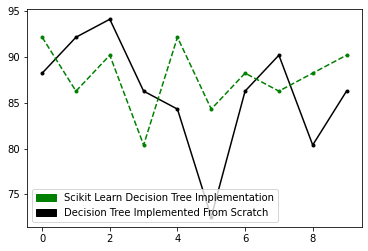

Average Performance using Scikit Learn Decision Tree Implementation 87.8431%
Average Performance using Decision Tree Implementation Made from Scratch 86.0784%


In [17]:
# import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#Signle Tree Tests sklearn v scratch implementation
preformaceSklearn = []
preformaceScratch = []

for i in range(10):
    trainData, testData = splitData(dataset)
    xtestIn,yTestOut=separateInputOutput(testData)
    xtrainIn,yTrainOut = separateInputOutput(trainData)

    #Test tree script developed from scratch
    treeScratch = createTree(xtrainIn,yTrainOut) 
    predictedYScratch = []
    for i in range(len(xtestIn)):
        predictionScratch = predictTree(xtestIn[i],treeScratch)
        predictedYScratch.append(predictionScratch)
    preformaceScratch.append(accuracy(predictedYScratch,yTestOut))
    
    #Sklearn 
    treeSklearn = tree.DecisionTreeClassifier()
    treeSklearn = treeSklearn.fit(xtrainIn, yTrainOut)
    sklearnTestPrdictionsTree  = treeSklearn.predict(xtestIn)
    preformaceSklearn.append(accuracy(sklearnTestPrdictionsTree,yTestOut))

sklearn = mpatches.Patch(color='green', label='Scikit Learn Decision Tree Implementation')
scratch = mpatches.Patch(color='black', label='Decision Tree Implemented From Scratch')
plt.legend(handles=[sklearn,scratch])
plt.plot(preformaceScratch,c='black',marker = '.')
plt.plot(preformaceSklearn,c='green',ls = '--',marker = '.')
plt.show()

print("Average Performance using Scikit Learn Decision Tree Implementation","{:.4f}%".format(sum(preformaceSklearn)/len(preformaceSklearn)))
print("Average Performance using Decision Tree Implementation Made from Scratch","{:.4f}%".format(sum(preformaceScratch)/len(preformaceScratch)))

In [63]:
noNorm = []
rangeNorm = []
zNorm = []
reps = 20

for i in range(reps):
    print("Iteration",i)
    trainSet, testSet = splitData(dataset)
    testIn, testOut = separateInputOutput(testSet)
    trainIn, trainOut = separateInputOutput(trainSet)

    trainIn_rangeNorm = normaliseData(trainIn, 'range')
    testIn_rangeNorm = normaliseData(testIn, 'range')

    trainIn_zNorm = normaliseData(trainIn, 'z')
    testIn_zNorm = normaliseData(testIn, 'z')

    forest = randomForestClassifierScratch(trainIn,trainOut,50)
    predicty = predictForest(testIn,forest)
    acc = accuracy(predicty,testOut)
    print("No norm accuracy = ", acc)
    noNorm.append(acc)

    forest = randomForestClassifierScratch(trainIn_zNorm,trainOut,50)
    predicty = predictForest(testIn_zNorm,forest)
    acc = accuracy(predicty,testOut)
    print("Range norm accuracy = ", acc)
    rangeNorm.append(acc)

    forest = randomForestClassifierScratch(trainIn_rangeNorm,trainOut,50)
    predicty = predictForest(testIn_rangeNorm,forest)
    acc = accuracy(predicty,testOut)
    print("Z norm accuracy = ", acc)
    zNorm.append(acc)


Iteration 0
No norm accuracy =  96.07843137254902
Range norm accuracy =  94.11764705882354
Z norm accuracy =  84.31372549019608
Iteration 1
No norm accuracy =  96.07843137254902
Range norm accuracy =  90.19607843137256
Z norm accuracy =  86.27450980392157
Iteration 2
No norm accuracy =  94.11764705882354
Range norm accuracy =  94.11764705882354
Z norm accuracy =  84.31372549019608
Iteration 3
No norm accuracy =  92.15686274509804
Range norm accuracy =  94.11764705882354
Z norm accuracy =  80.3921568627451
Iteration 4
No norm accuracy =  80.3921568627451
Range norm accuracy =  76.47058823529412
Z norm accuracy =  78.43137254901961


In [64]:
print("Mean no norm = {}".format(np.array(noNorm).mean()))
print("Mean range norm = {}".format(np.array(rangeNorm).mean()))
print("Mean z norm = {}".format(np.array(zNorm).mean()))

Mean no norm = 91.76470588235293
Mean range norm = 89.80392156862744
Mean z norm = 82.74509803921569


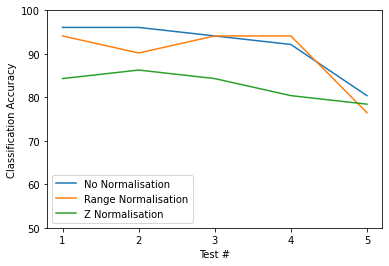

In [83]:
plt.plot(noNorm, label='No Normalisation')
plt.plot(rangeNorm, label='Range Normalisation')
plt.plot(zNorm, label='Z Normalisation')
plt.ylim([50,100])
plt.xlabel("Test #")
plt.ylabel("Classification Accuracy")
plt.xticks(np.arange(len(noNorm)),np.linspace(1,len(noNorm),len(noNorm)).astype(np.int))
plt.legend()
plt.show()